In [144]:
%pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.7 MB/s eta 0:00:00


In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import seaborn as sns
import datetime

from collections import Counter
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import DBSCAN, KMeans, Birch, AgglomerativeClustering
from tqdm import tqdm

In [111]:
!gdown 1Nwo_5m6jKiBhh-ftEbJ8EXb5jdl1bHRB

Downloading...
From: https://drive.google.com/uc?id=1Nwo_5m6jKiBhh-ftEbJ8EXb5jdl1bHRB
To: /content/results_triplets_sravni.csv
100% 7.58M/7.58M [00:00<00:00, 137MB/s]


## ***Готовим датасет***

In [112]:
data = pd.read_csv('/content/preds_main.csv')
data['timestamp'] = data['timestamp'].replace({'27.04.2024:19:00': '2024-04-27 19:00:00'})
# data

In [113]:
def preprocess_triplets(res, triplets_columns="triplets", date_column="timestamp"):
  triplets = res[triplets_columns].values.tolist()
  dates = res[date_column].values.tolist()
  all_triplets = []
  for i, label in enumerate(triplets):
      all_triplets.extend([list(item) + [dates[i]] for item in eval(label)])

  data = []
  for triplet in all_triplets:
      at, ot, sp, ts = triplet
      at = at.lower()
      ot = ot.lower()

      data.append([ts, at, ot, sp, (at, ot, sp), (at, ot)])
  data = pd.DataFrame(data)
  data.columns = ['date', 'aspect', 'opinion', 'sentiment', 'triplet', 'aspect_opinion']

  data["timestamp"] = data["date"].apply(lambda x: datetime.datetime.fromisoformat(x).timestamp())

  return data

In [114]:
data = preprocess_triplets(data)

## **Графики**

### ***Гистограмма тональности***

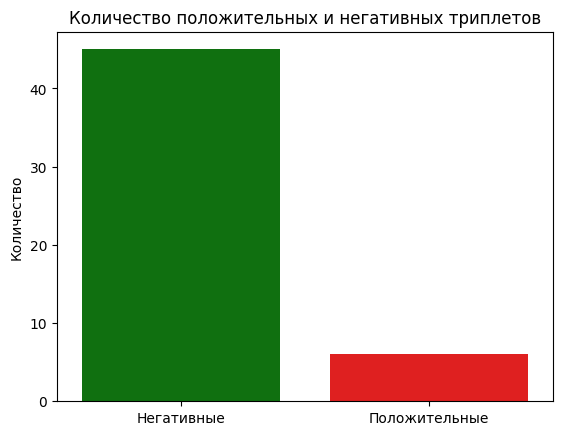

In [115]:
def sentiment_hist(data, column):
  colors = {"POS": 'green', "NEG": 'red'}
  sns.countplot(x="sentiment", data=data, hue="sentiment", palette=colors)
  plt.title('Количество положительных и негативных триплетов')
  plt.xticks([0, 1], labels=['Негативные', 'Положительные'])
  plt.xlabel('')
  plt.ylabel('Количество')
  plt.show()

sentiment_hist(data, "sentiment")

### ***Отнонешние тональностей с течением времени***

In [160]:
def common_sentiment_bytime(data):
  data_sorted = data.sort_values("timestamp", ascending=True)

  def count_pos_neg(group):
    sent_dict = {"count_pos" : 0, "count_neg" : 0}
    for item in group:
      if item == "POS": sent_dict["count_pos"] += 1
      else: sent_dict["count_neg"] += 1
    return sent_dict

  counted_sentiment = data_sorted.groupby("date")[["sentiment"]].agg(count_pos_neg).reset_index(names=["date"])

  count_pos = 1; count_neg = 1;
  ratio = []
  for i, item in counted_sentiment.iterrows():
    count_pos += item["sentiment"]["count_pos"]
    count_neg += item["sentiment"]["count_neg"]
    # ratio.append(count_pos / count_neg )
    ratio.append(100 * count_pos / (count_neg + count_pos))

  smoothing_k = 2
  data_ratio = counted_sentiment[["date"]].iloc[::smoothing_k]
  data_ratio["Доля положительных"] = ratio[::smoothing_k]

  fig = px.line(data_ratio, x="date", y="Доля положительных")
  fig.update_yaxes(range=[min(ratio)-1, max(ratio)+1], autorange=False)
#   fig.get_axes().set_ylim(min(ratio)-1, max(ratio)+1)
  fig.update_layout(scattermode="group")
#   fig.yaxis_title('Доля положительных триплетов')
#   fig.xaxis_title('Дата')
  fig.update_layout(
    title=f'Доля положительных триплетов по времени',
    xaxis_title='Дата',
    yaxis_title='Доля положительных триплетов',
    )
  fig.show()

In [161]:
common_sentiment_bytime(data)

### ***тональность по аспектам с течением времени***

In [162]:
# сюда вставить аспект

def aspect_sentiment_bytime(data, aspect):
  aspect_data = data.groupby("aspect").get_group(aspect).sort_values("timestamp")

  def count_pos_neg(group):
    sent_dict = {"count_pos" : 0, "count_neg" : 0}
    for item in group:
      if item == "POS": sent_dict["count_pos"] += 1
      else: sent_dict["count_neg"] += 1
    return sent_dict
  counted_sentiment = aspect_data.groupby("date")[["sentiment"]].agg(count_pos_neg).reset_index(names=["date"])

  count_pos = 1; count_neg = 1;
  ratio = []
  for i, item in counted_sentiment.iterrows():
    count_pos += item["sentiment"]["count_pos"]
    count_neg += item["sentiment"]["count_neg"]
    ratio.append(100 * count_pos / (count_neg + count_pos))

  smoothing_k = 1
  data_ratio = counted_sentiment[["date"]].iloc[::smoothing_k]
  data_ratio["Доля положительных"] = ratio[::smoothing_k]


  fig = px.line(data_ratio, x="date", y="Доля положительных")
  fig.update_yaxes(range=[min(ratio)-1, max(ratio)+1], autorange=False)
  fig.update_layout(
    title=f'Зависимость доли положительных триплетов, Аспект - "{aspect}"',
    xaxis_title='Дата',
    yaxis_title='Доля положительных триплетов',
    )
  fig.update_layout(scattermode="group")
  fig.show()

In [163]:
aspect_sentiment_bytime(data, "изучение")

*идея: попробовать выделять сезонность в данном графике*

### ***самые частые триплеты***

In [120]:
def get_most_common_triplets(data, n):
  return [[as_, op, st, count] for (as_, op, st), count in Counter(data.triplet).most_common(n)]

In [121]:
get_most_common_triplets(data, 5)

[['изучение', 'глубокое', 'POS', 7],
 ['объяснение', 'ясное', 'POS', 3],
 ['подход', 'интерактивный', 'POS', 2],
 ['обсуждение', 'скучным', 'NEG', 2],
 ['анализ', 'глубокий', 'POS', 2]]

### ***Гисторгамма самых негативных аспектов***

In [158]:
def get_most_neg_aspects(data, n):
  fig, ax = plt.subplots(layout='constrained')
  result = data[data.sentiment=='NEG'].groupby('aspect').size().sort_values(ascending=False).iloc[:n]
  sns.barplot(x=result.index, y=result.values)
  ax.set_xlabel("Аспект")
  ax.set_ylabel("Кол-во положительных триплетов")
  ax.set_title("Cамые негативные аспекты")
  plt.xticks(fontsize=12, rotation=30)
  plt.yticks(list(range(max(result.values)+1)), fontsize=12);


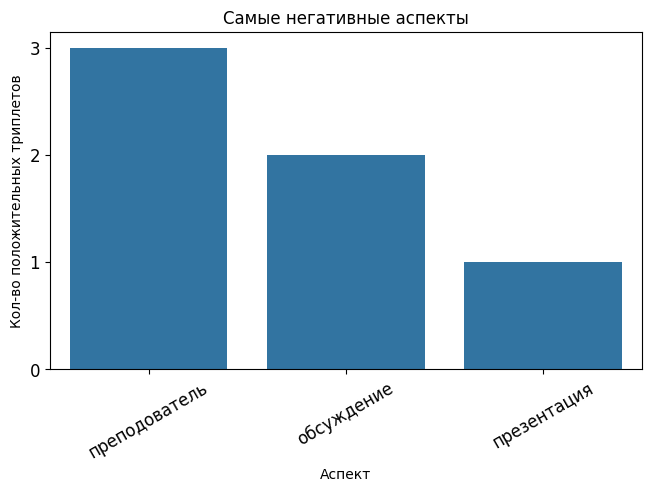

In [159]:
get_most_neg_aspects(data, 10)

### ***Гисторгамма самых положительных аспектов***

In [156]:
def get_most_pos_aspects(data, n):
  fig, ax = plt.subplots(layout='constrained')
  result = data[data.sentiment=='POS'].groupby('aspect').size().sort_values(ascending=False).iloc[:10]
  sns.barplot(x=result.index, y=result.values)
  plt.xticks(fontsize=10, rotation=30)
  ax.set_xlabel("Аспект")
  ax.set_ylabel("Кол-во положительных триплетов")
  ax.set_title("Самые позитивные аспекты")

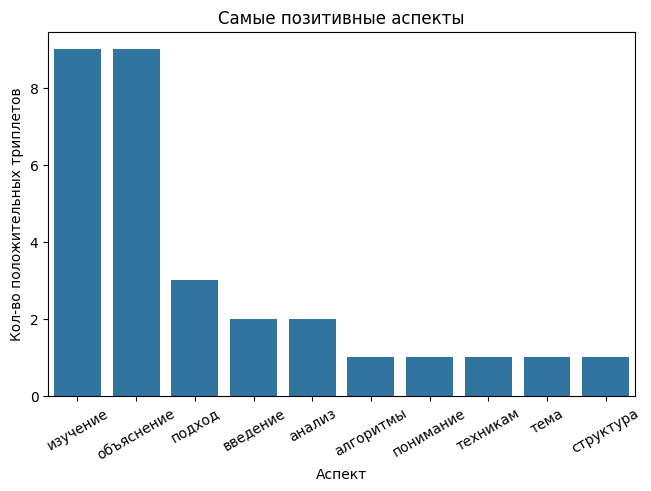

In [157]:
get_most_pos_aspects(data, 10)

### ***Посмотрим то же самое в доле положительных триплетов***

#### **по убыванию**

In [126]:
def get_most_neg_ratio_aspects(data, n):
  def get_part_of_pos_sentiments(x):
    if len(x) >= 3:
        return len(x[x=='NEG'])/len(x)
    else:
        return -1

  return data.groupby('aspect').agg({'sentiment': get_part_of_pos_sentiments})['sentiment'].sort_values(ascending=False)[:n].to_dict()

In [127]:
def get_most_pos_ratio_aspects(data, n):
  def get_part_of_pos_sentiments(x):
    if len(x) >= 3:
        return len(x[x=='POS'])/len(x)
    else:
        return -1

  return data.groupby('aspect').agg({'sentiment': get_part_of_pos_sentiments})['sentiment'].sort_values(ascending=False)[:n].to_dict()

In [128]:
get_most_pos_ratio_aspects(data, 10), get_most_neg_ratio_aspects(data, 10)

({'подход': 1.0,
  'изучение': 1.0,
  'объяснение': 1.0,
  'обсуждение': 0.3333333333333333,
  'преподователь': 0.25,
  'понимание': -1.0,
  'техникам': -1.0,
  'тема': -1.0,
  'структура': -1.0,
  'ресурсы': -1.0},
 {'преподователь': 0.75,
  'обсуждение': 0.6666666666666666,
  'подход': 0.0,
  'изучение': 0.0,
  'объяснение': 0.0,
  'понимание': -1.0,
  'техникам': -1.0,
  'тема': -1.0,
  'структура': -1.0,
  'ресурсы': -1.0})

### ***Гистограмма популярности пар аспект-мнение***

In [152]:
def get_most_popular_aspect_opinion(data, n="all"):
  data["aspect-opinion"] = data["aspect_opinion"].apply(lambda x: x[0]+"-"+x[1])
  most_common_pairs = pd.DataFrame(Counter(data["aspect-opinion"]).most_common(10), columns=["pair", "count"])
  most_common_pairs_series = pd.Series(list(most_common_pairs["count"]), index=list(most_common_pairs["pair"]))[:10]
  fig, ax = plt.subplots(layout='constrained')
#   ax.bar(x=most_common_pairs_series.index, height=most_common_pairs_series.values)
  sns.barplot(x=most_common_pairs_series.index, y=most_common_pairs_series.values)
  plt.xticks(rotation=75)
  ax.set_xlabel("Аспект-мнение")
  ax.set_ylabel("Встречаемость")
  ax.set_title("Cамые частые пары аспект-мнение")

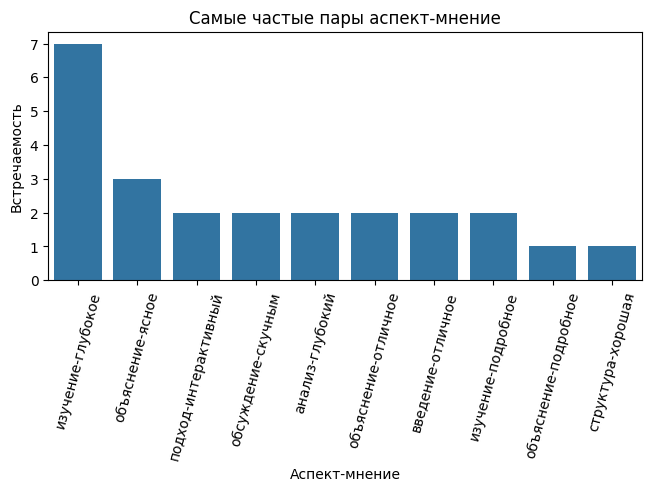

In [153]:
get_most_popular_aspect_opinion(data, 12)

### ***Облака слов для аспектов и мнений***

In [139]:
def simple_wordcloud_aspect(data):
  cloud_aspect = WordCloud(background_color="#ffffff", contour_width=20, contour_color='#2e3043', colormap="Set2", max_words=20).generate(text=' '.join(data["aspect"]))
  plt.imshow(cloud_aspect)
  plt.axis('off')
  plt.show()

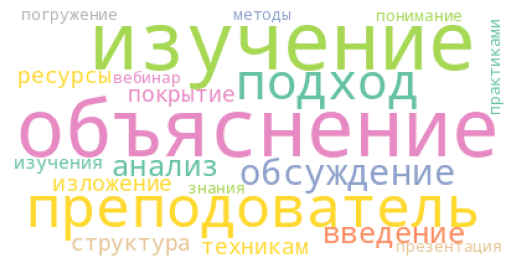

In [140]:
simple_wordcloud_aspect(data)

In [141]:
def simple_wordcloud_opinion(data):
  cloud_opinion = WordCloud(background_color="#ffffff", max_words=20).generate(text=' '.join(data["opinion"]))
  plt.imshow(cloud_opinion)
  plt.axis('off')
  plt.show()

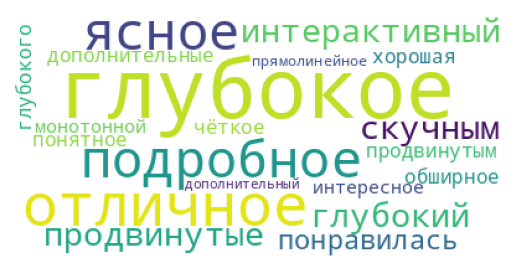

In [142]:
simple_wordcloud_opinion(data)

### **Класстеризация аспектов**

In [145]:
import umap

def cluster_aspects(data):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")
  model = AutoModel.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")

  model.to(device)

  aspects = set(data.aspect.tolist())
  embeddings = []

  for aspect in tqdm(aspects):

      encoded_input = tokenizer(aspect, padding=False, return_tensors='pt').to(device)

      with torch.no_grad():
          model_output = model(**encoded_input)

      embeddings.append(model_output.last_hidden_state.mean(dim=1))

  embeddings = torch.stack(embeddings).cpu().numpy().squeeze(1)

  reducer8 = umap.UMAP(n_components=4)
  reducer2 = umap.UMAP(n_components=2)

  embeds_reduced8 = reducer8.fit_transform(embeddings)
  embeds_reduced2 = reducer2.fit_transform(embeddings)

  clusters = DBSCAN(n_jobs=-1, min_samples=1).fit(embeds_reduced8)
  df = pd.DataFrame(embeds_reduced2[:, 0], columns=["x"])
  df["y"] = embeds_reduced2[:, 1]; df["color"] = clusters.labels_; df["aspect"] = list(aspects)
  # df["size"] = df["aspect"].apply(lambda x: len(data[data.aspect == x]) / 10)

  return px.scatter(df, x="x", y="y", color="color", hover_data={"text": df["aspect"]})

In [146]:
fig = cluster_aspects(data)
fig

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/377 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


In [147]:
import umap

def cluster_opinions(data):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")
  model = AutoModel.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")

  model.to(device)

  opinions = set(data.opinion.tolist())
  embeddings = []

  for opinion in tqdm(opinions):

      encoded_input = tokenizer(opinion, padding=False, return_tensors='pt').to(device)

      with torch.no_grad():
          model_output = model(**encoded_input)

      embeddings.append(model_output.last_hidden_state.mean(dim=1))

  embeddings = torch.stack(embeddings).cpu().numpy().squeeze(1)

  reducer8 = umap.UMAP(n_components=8)
  reducer2 = umap.UMAP(n_components=2)

  embeds_reduced8 = reducer8.fit_transform(embeddings)
  embeds_reduced2 = reducer2.fit_transform(embeddings)

  clusters = DBSCAN(n_jobs=-1, min_samples=4).fit(embeds_reduced8)
  df = pd.DataFrame(embeds_reduced2[:, 0], columns=["x"])
  df["y"] = embeds_reduced2[:, 1]; df["color"] = clusters.labels_; df["opinion"] = list(opinions)
  # df["size"] = df["aspect"].apply(lambda x: len(data[data.aspect == x]) / 10)

  return px.scatter(df, x="x", y="y", color="color", hover_data={"text": df["opinion"]})

In [148]:
fig = cluster_opinions(data)

100%|██████████| 31/31 [00:00<00:00, 169.49it/s]


In [149]:
fig

In [ ]:
def cluster_aspect_optinion(data):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
  model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

  model.to(device)

  aspect_opinions = set(data.aspect_opinion.tolist())
  embeddings = []

  for aspect_opinion in tqdm(aspect_opinions):

      encoded_input = tokenizer(aspect_opinion, padding=False, return_tensors='pt').to(device)

      with torch.no_grad():
          model_output = model(**encoded_input)

      embeddings.append(model_output.last_hidden_state.mean(dim=1))

  embeddings = torch.stack(embeddings).cpu().numpy().squeeze(1)

  reducer8 = umap.UMAP(n_components=8)
  reducer2 = umap.UMAP(n_components=2)

  embeds_reduced8 = reducer8.fit_transform(embeddings)
  embeds_reduced2 = reducer2.fit_transform(embeddings)

  clusters = DBSCAN(n_jobs=-1, min_samples=4).fit(embeds_reduced8)
  df = pd.DataFrame(embeds_reduced2[:, 0], columns=["x"])
  df["y"] = embeds_reduced2[:, 1]; df["color"] = clusters.labels_; df["aspect-opinion"] = list(aspect_opinions)

  return px.scatter(df, x="x", y="y", color="color", hover_data={"text": df["aspect-opinion"]})

In [ ]:
fig = cluster_aspect_optinion(data)
fig

100%|██████████| 16/16 [00:02<00:00,  6.08it/s]


In [ ]:
def get_statistics_by_aspect(data, aspect):
  info_dict = {"pos-ratio" : 0, "neg-ratio" : 0, "neg-count" : 0, "pos-count" : 0}
  aspect_data = data[data.aspect == aspect]
  if len(aspect_data) == 0: return info_dict
  info_dict["neg-count"] = len(aspect_data[aspect_data["sentiment"] == "NEG"])
  info_dict["pos-count"] = len(aspect_data[aspect_data["sentiment"] == "POS"])
  info_dict["pos-ratio"] = info_dict["pos-count"] / (info_dict["pos-count"] + info_dict["neg-count"])
  info_dict["neg-ratio"] = info_dict["neg-count"] / (info_dict["pos-count"] + info_dict["neg-count"])
  # доля положительных/негативных, релевантность, object
  return info_dict

In [ ]:
get_statistics_by_aspect(data, "преподователь")

{'pos-ratio': 0.25, 'neg-ratio': 0.75, 'neg-count': 3, 'pos-count': 1}

In [ ]:
def get_statistics_by_aspect_opinion(data, aspect, opinion):
  info_dict = {"pos-ratio" : 0, "neg-ratio" : 0, "neg-count" : 0, "pos-count" : 0}
  asop_data = data[(data["aspect"] == aspect) & (data["opinion"] == opinion)]
  if len(asop_data) == 0: return info_dict
  info_dict["neg-count"] = len(asop_data[asop_data["sentiment"] == "NEG"])
  info_dict["pos-count"] = len(asop_data[asop_data["sentiment"] == "POS"])
  info_dict["pos-ratio"] = info_dict["pos-count"] / (info_dict["pos-count"] + info_dict["neg-count"])
  info_dict["neg-ratio"] = info_dict["neg-count"] / (info_dict["pos-count"] + info_dict["neg-count"])
  # доля положительных/негативных, релевантность, object
  return info_dict

In [ ]:
get_statistics_by_aspect_opinion(data, "изучение", "глубокое")

{'pos-ratio': 1.0, 'neg-ratio': 0.0, 'neg-count': 0, 'pos-count': 7}

In [ ]:
def sentiment_hist(data):
  colors = {1: 'green', 0: 'red'}
  sns.countplot(x="sent", data=data, hue="sent", palette="rainbow")
  plt.title('Количество положительных и негативных отзывов')
  plt.xticks([0, 1], labels=['Негативные', 'Положительные'])
  plt.xlabel('')
  plt.ylabel('Количество')
  plt.show()

def relevant_hist(data):
  colors = {1: 'green', 0: 'red'}
  sns.countplot(x="rel", data=data, hue="rel", palette="rainbow")
  plt.title('Количество релевантных и нерелевантных отзывов')
  plt.xticks([0, 1], labels=['Нерелевантные', 'Релевантные'])
  plt.xlabel('')
  plt.ylabel('Количество')
  plt.show()

def object_hist(data):
  colors = {1: 'green', 0: 'red', 2 : "blue"}
  sns.countplot(x="obj", data=data, hue="obj", palette="rainbow")
  plt.title('Основной объект отзыва')
  plt.xticks([0, 1, 2], labels=['Вебинар', 'Программа', 'Преподаватель'])
  plt.xlabel('')
  plt.ylabel('Количество')
  plt.show()

object_hist(pd.read_csv("/content/preds_main.csv"))
relevant_hist(pd.read_csv("/content/preds_main.csv"))
sentiment_hist(pd.read_csv("/content/preds_main.csv"))

In [ ]:
from transformers import pipeline

def plot_emotions(data):
  eng_to_rus = {'admiration': 'восхищение',
  'amusement': 'веселье',
  'anger': 'злость',
  'annoyance': 'раздражение',
  'approval': 'одобрение',
  'caring': 'забота',
  'confusion': 'непонимание',
  'curiosity': 'любопытство',
  'desire': 'желание',
  'disappointment': 'разочарование',
  'disapproval': 'неодобрение',
  'disgust': 'отвращение',
  'embarrassment': 'смущение',
  'excitement': 'возбуждение',
  'fear': 'страх',
  'gratitude': 'признательность',
  'grief': 'горе',
  'joy': 'радость',
  'love': 'любовь',
  'nervousness': 'нервозность',
  'optimism': 'оптимизм',
  'pride': 'гордость',
  'realization': 'осознание',
  'relief': 'облегчение',
  'remorse': 'раскаяние',
  'sadness': 'грусть',
  'surprise': 'удивление',
  'neutral': 'нейтральность',}


  fig, ax = plt.subplots(figsize=(9, 9))
  plt.title('Эмоции в отзывах студентов')
  plt.ylabel('Встречаемость эмоции')
  plt.xlabel('Эмоция')
  sns.countplot(x=data["emotion"])
  plt.xticks(list(range(len(data["emotion"].value_counts().index))), labels=[eng_to_rus[i] for i in data["emotion"].value_counts().index], fontsize=12, rotation=30);

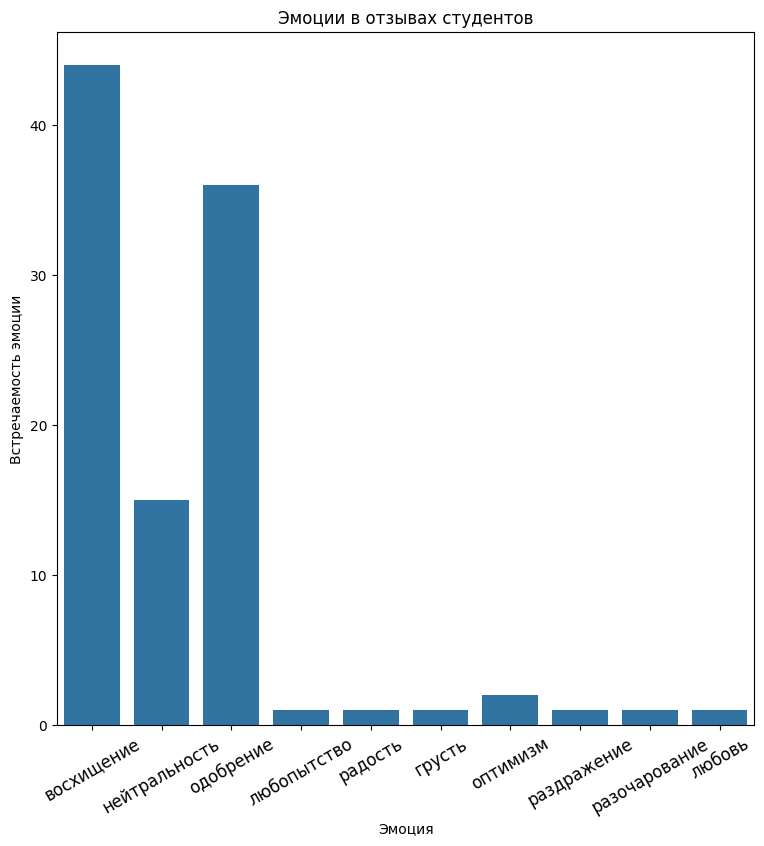

In [ ]:
plot_emotions(pd.read_csv("/content/preds_main.csv"))